### Importing modules

In [1]:
!pip install tensorflow

In [2]:
!pip install keras-tuner --upgrade

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras.layers import LSTM, Dense , Dropout, Flatten, ConvLSTM2D, RepeatVector
import keras_tuner as kt

### Data preparation

In [6]:
train_set= pd.read_csv("Data/train_motion_data.csv")
test_set=pd.read_csv("Data/test_motion_data.csv")

In [7]:
train_set

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631
...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,SLOW,3583789
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,SLOW,3583790
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,SLOW,3583790
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,SLOW,3583791


In [8]:
test_set

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.758194,-0.217791,0.457263,0.000000,0.000000,0.000000,AGGRESSIVE,818922
1,0.667560,-0.038610,0.231416,-0.054367,-0.007712,0.225257,AGGRESSIVE,818923
2,2.724449,-7.584121,2.390926,0.023824,0.013668,-0.038026,AGGRESSIVE,818923
3,2.330950,-7.621754,2.529024,0.056810,-0.180587,-0.052076,AGGRESSIVE,818924
4,2.847215,-6.755621,2.224640,-0.031765,-0.035201,0.035277,AGGRESSIVE,818924
...,...,...,...,...,...,...,...,...
3079,-0.713858,-0.652975,-0.164015,-0.147829,-1.309466,0.517250,SLOW,820706
3080,1.514261,0.330070,1.020714,1.321302,1.707598,-0.674548,SLOW,820707
3081,1.280216,-1.735172,-2.332695,0.583376,0.690507,-0.468075,SLOW,820707
3082,0.912313,0.583314,-0.965622,0.235794,0.512745,0.406073,SLOW,820708


In [9]:
# Global constants
TIMESTEPS =20
FEATURES =6
LABELS=2
N_RECORDS =10

#CNN constants
N_COLUMNS = 4
N_LENGTH = TIMESTEPS //N_COLUMNS
N_ROWS =1

In [10]:
# Splitting the samples by class

df_train_normal=train_set.loc[train_set['Class']=="NORMAL"]
df_train_slow=train_set.loc[train_set['Class']=="SLOW"]
df_train_aggressive=train_set.loc[train_set['Class']=="AGGRESSIVE"]


In [11]:
df_test_normal=test_set.loc[test_set['Class']=="NORMAL"]
df_test_slow=test_set.loc[test_set['Class']=="SLOW"]
df_test_aggressive=test_set.loc[test_set['Class']=="AGGRESSIVE"]

### Plotting 3 driving behaviours against accX , accY and accZ

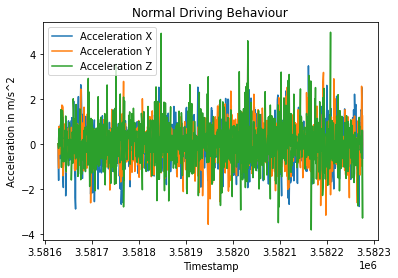

In [12]:
plt.plot(df_train_normal['Timestamp'],df_train_normal['AccX'],label="Acceleration X")
plt.plot(df_train_normal['Timestamp'],df_train_normal['AccY'],label="Acceleration Y")
plt.plot(df_train_normal['Timestamp'],df_train_normal['AccZ'],label="Acceleration Z")

plt.title("Normal Driving Behaviour")
plt.xlabel("Timestamp")
plt.ylabel("Acceleration in m/s^2")
plt.legend(loc='upper left')
plt.show()

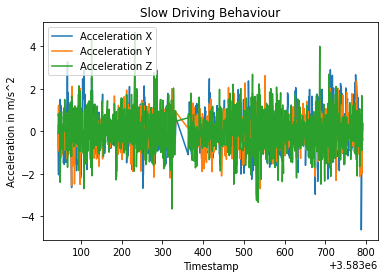

In [13]:
plt.plot(df_train_slow['Timestamp'],df_train_slow['AccX'],label="Acceleration X")
plt.plot(df_train_slow['Timestamp'],df_train_slow['AccY'],label="Acceleration Y")
plt.plot(df_train_slow['Timestamp'],df_train_slow['AccZ'],label="Acceleration Z")

plt.title("Slow Driving Behaviour")
plt.xlabel("Timestamp")
plt.ylabel("Acceleration in m/s^2")
plt.legend(loc='upper left')
plt.show()

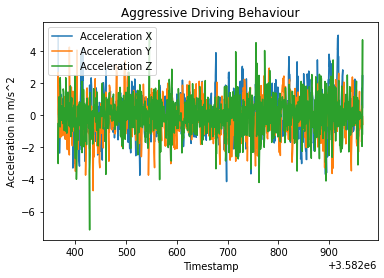

In [14]:
plt.plot(df_train_aggressive['Timestamp'],df_train_aggressive['AccX'],label="Acceleration X")
plt.plot(df_train_aggressive['Timestamp'],df_train_aggressive['AccY'],label="Acceleration Y")
plt.plot(df_train_aggressive['Timestamp'],df_train_aggressive['AccZ'],label="Acceleration Z")

plt.title("Aggressive Driving Behaviour")
plt.xlabel("Timestamp")
plt.ylabel("Acceleration in m/s^2")
plt.legend(loc='upper left')
plt.show()

### Plotting 3 driving behaviours against GyroX , GyroY and GyroZ

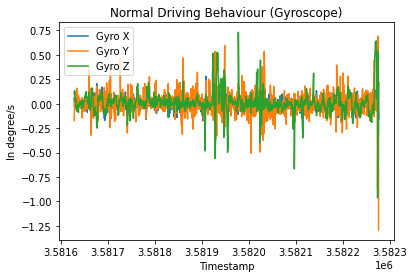

In [15]:
plt.plot(df_train_normal['Timestamp'],df_train_normal['GyroX'],label="Gyro X")
plt.plot(df_train_normal['Timestamp'],df_train_normal['GyroY'],label="Gyro Y")
plt.plot(df_train_normal['Timestamp'],df_train_normal['GyroZ'],label="Gyro Z")

plt.title("Normal Driving Behaviour (Gyroscope)")
plt.xlabel("Timestamp")
plt.ylabel("In degree/s")
plt.legend(loc='upper left')
plt.show()

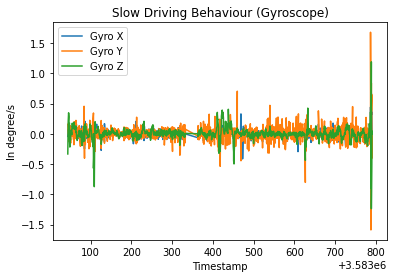

In [16]:
plt.plot(df_train_slow['Timestamp'],df_train_slow['GyroX'],label="Gyro X")
plt.plot(df_train_slow['Timestamp'],df_train_slow['GyroY'],label="Gyro Y")
plt.plot(df_train_slow['Timestamp'],df_train_slow['GyroZ'],label="Gyro Z")

plt.title("Slow Driving Behaviour (Gyroscope)")
plt.xlabel("Timestamp")
plt.ylabel("In degree/s")
plt.legend(loc='upper left')
plt.show()

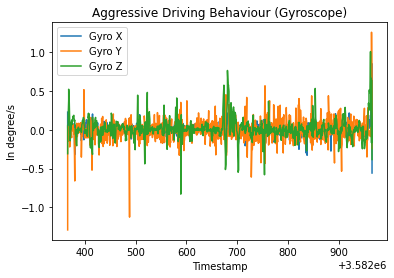

In [17]:
plt.plot(df_train_aggressive['Timestamp'],df_train_aggressive['GyroX'],label="Gyro X")
plt.plot(df_train_aggressive['Timestamp'],df_train_aggressive['GyroY'],label="Gyro Y")
plt.plot(df_train_aggressive['Timestamp'],df_train_aggressive['GyroZ'],label="Gyro Z")

plt.title("Aggressive Driving Behaviour (Gyroscope)")
plt.xlabel("Timestamp")
plt.ylabel("In degree/s")
plt.legend(loc='upper left')
plt.show()

### Removing N_RECORDS data from first and last of each set that is caused due to class switching

In [18]:
df_train_slow= df_train_slow.iloc[N_RECORDS:]
df_train_slow= df_train_slow.iloc[:-N_RECORDS]

df_train_normal= df_train_normal.iloc[N_RECORDS:]
df_train_normal= df_train_normal.iloc[:-N_RECORDS]

df_train_aggressive= df_train_aggressive.iloc[N_RECORDS:]
df_train_aggressive= df_train_aggressive.iloc[:-N_RECORDS]



In [19]:
df_test_slow= df_test_slow.iloc[N_RECORDS:]
df_test_slow= df_test_slow.iloc[:-N_RECORDS]

df_test_normal= df_test_normal.iloc[N_RECORDS:]
df_test_normal= df_test_normal.iloc[:-N_RECORDS]

df_test_aggressive= df_test_aggressive.iloc[N_RECORDS:]
df_test_aggressive= df_test_aggressive.iloc[:-N_RECORDS]


In [20]:
# Checking data per label

print('----Train----')
print("Slow samples: "+str(df_train_slow.__len__()))
print("Normal samples: "+str(df_train_normal.__len__()))
print("Aggressive samples: "+str(df_train_aggressive.__len__()))

df_train_slow=df_train_slow.tail(1300)
df_train_normal=df_train_normal.tail(1160)
df_train_aggressive=df_train_aggressive.tail(1080)


----Train----
Slow samples: 1311
Normal samples: 1180
Aggressive samples: 1093


In [21]:
print('----Test----')
print("Slow samples: "+str(df_test_slow.__len__()))
print("Normal samples: "+str(df_test_normal.__len__()))
print("Aggressive samples: "+str(df_test_aggressive.__len__()))

df_test_slow=df_test_slow.tail(1250)
df_test_normal=df_test_normal.tail(970)
df_test_aggressive=df_test_aggressive.tail(790)

----Test----
Slow samples: 1253
Normal samples: 977
Aggressive samples: 794


In [22]:
#separating features from labels

#train
X_train_normal = df_train_normal.iloc[:,:FEATURES]
X_train_slow = df_train_slow.iloc[:,:FEATURES]
X_train_aggressive = df_train_aggressive.iloc[:,:FEATURES]

#test
X_test_normal = df_test_normal.iloc[:,:FEATURES]
X_test_slow = df_test_slow.iloc[:,:FEATURES]
X_test_aggressive = df_test_aggressive.iloc[:,:FEATURES]

#train
Y_train_normal=df_train_normal.Class
Y_train_slow=df_train_slow.Class
Y_train_aggressive=df_train_aggressive.Class

Y_test_normal=df_test_normal.Class
Y_test_slow=df_test_slow.Class
Y_test_aggressive=df_test_aggressive.Class
X_train_normal




,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
30,-2.311000,-0.000236,1.234169,0.013592,-0.145386,-0.044670
31,-1.235491,-1.186430,-0.450856,-0.000458,0.058032,-0.017181
32,-0.057978,-1.254435,-1.226808,-0.029780,0.015272,0.031689
33,0.735135,-0.594205,0.560677,0.009927,-0.021991,-0.016570
34,-0.184486,-0.286318,0.456868,-0.016952,-0.018937,-0.009850
...,...,...,...,...,...,...
1185,-2.784989,-0.799035,1.176996,0.123547,-0.031154,0.564974
1186,0.015490,-0.433339,0.655057,0.108276,0.000611,0.630947
1187,-0.105201,-0.721263,0.783494,0.138208,-0.003665,0.632780
1188,-0.507179,-1.385926,0.045160,0.114995,-0.073304,0.643165


In [23]:
# combine all the samples into a train and test dataset

X_train=pd.concat([X_train_normal,X_train_aggressive])
Y_train=pd.concat([Y_train_normal,Y_train_aggressive])

X_test=pd.concat([X_test_normal,X_test_aggressive])
Y_test=pd.concat([Y_test_normal,Y_test_aggressive])
'''X_train'''
Y_train


30          NORMAL
31          NORMAL
32          NORMAL
33          NORMAL
34          NORMAL
           ...    
2298    AGGRESSIVE
2299    AGGRESSIVE
2300    AGGRESSIVE
2301    AGGRESSIVE
2302    AGGRESSIVE
Name: Class, Length: 2240, dtype: object

In [24]:
# Mapping labels to numbers
labelEncoder = LabelEncoder()
Y_train=labelEncoder.fit_transform(Y_train)
Y_test=labelEncoder.transform(Y_test)

In [25]:
# Converting to one hot encoded vectors
Y_train = to_categorical(Y_train, num_classes=LABELS)
Y_test = to_categorical(Y_test, num_classes=LABELS)

In [26]:
# scaling data
scaler = StandardScaler(with_mean = True , with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
#Reshaping the input for the Conv_LSTM network (Features)
train_samples = X_train.shape[0]//TIMESTEPS
X_train =X_train.reshape(train_samples, N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)


test_samples = X_test.shape[0]//TIMESTEPS
X_test =X_test.reshape(test_samples, N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)

print('Train features shape: '+str(X_train.shape[0]))
print('Test features shape:' + str(X_test.shape[0]))

Train features shape: 112
Test features shape:88


In [28]:
Y_train=Y_train[::TIMESTEPS]
Y_test=Y_test[::TIMESTEPS]

print('Train labels shape: '+str(Y_train.shape[0]))
print('Test labels shape: '+str(Y_test.shape[0]))

Train labels shape: 112
Test labels shape: 88


In [29]:
tf.random.set_seed(42)

# Build the model by assigning
# the number of layers and number of neurons for each layer
# the learning rate
# the number of epochs
# ------------------------------------------------------------------------
# To get these optimal parameters I will use the Keras Tuner library
# so it will get the optimal parameters for the NN
# and pass it to the model_builder function
def model_builder(hp):
    model = tf.keras.Sequential()

    model.add(
        ConvLSTM2D(
            filters=hp.Int('filter_units', min_value=16, max_value=64, step=16),
            kernel_size=(1,3), 
            activation='relu', 
            input_shape=(N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)
            )
        )
        
    model.add(Dropout(hp.Float('dropout_0_rate', min_value=0, max_value=0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu'))

    model.add(Dense(LABELS, activation='softmax'))
    

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [30]:
# To be able to get the optimal parameters for our network
# we have to create a Tuner with the following setup
# 'objective' -> will use to create test models
# 'max_epochs' -> the maximum number of epochs to train one model
# 'factor' -> the reduction factor for the number of epochs and number of models for each bracket
# 'directory' -> will save the training history there
tuner= kt.Hyperband(model_builder,
                   objective='val_accuracy',
                   max_epochs=50,
                   factor=3,
                   directory='bin_conv_lstm_dir',
                   project_name='driving_behaviour')

In [31]:
#Stop early function
stop_early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [32]:
#considering the top_performing mode

tuner.search(
    x=X_train,
    y=Y_train,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[stop_early],
    shuffle=True
)

Trial 90 Complete [00h 00m 07s]
val_accuracy: 0.75

Best val_accuracy So Far: 0.7727272510528564
Total elapsed time: 00h 10m 16s
INFO:tensorflow:Oracle triggered exit


In [33]:
# Get best hyperparameters that were found during the search
best_model = tuner.get_best_models()[0]

In [35]:
# Get the metrics for our trained model
eval_result = best_model.evaluate(X_test, Y_test)

3/3 [==============================] - 1s 7ms/step - loss: 0.9832 - accuracy: 0.7727 - precision: 0.7727 - recall: 0.7727


In [36]:
# Get the predictions
Y_pred=best_model.predict(x=X_test)

3/3 [==============================] - 0s 7ms/step


In [37]:
# Transform the predicted scores array to a pretty Dataframe
df_predicted = pd.DataFrame(Y_pred, columns=['AGGRESSIVE', 'NORMAL'])
df_predicted

,AGGRESSIVE,NORMAL
0,0.088832,9.111681e-01
1,0.133033,8.669667e-01
2,0.011653,9.883472e-01
3,0.999637,3.630825e-04
4,0.167469,8.325307e-01
...,...,...
83,0.987520,1.247952e-02
84,0.999986,1.429612e-05
85,0.999747,2.534798e-04
86,0.942746,5.725451e-02


In [39]:
# Reverse the one hot encoded vector
actual_y_test = np.argmax(Y_test, axis=1)
array_actual = labelEncoder.inverse_transform(actual_y_test)

# Transform the given class array to a Dataframe
df_actual = pd.DataFrame(array_actual, columns = ['Original Class'])
df_actual

,Original Class
0,NORMAL
1,NORMAL
2,NORMAL
3,NORMAL
4,NORMAL
...,...
83,AGGRESSIVE
84,AGGRESSIVE
85,AGGRESSIVE
86,AGGRESSIVE


In [40]:
# Combine the actual and resulted classes
df_result = pd.concat([df_predicted, df_actual], axis=1)
df_result

,AGGRESSIVE,NORMAL,Original Class
0,0.088832,9.111681e-01,NORMAL
1,0.133033,8.669667e-01,NORMAL
2,0.011653,9.883472e-01,NORMAL
3,0.999637,3.630825e-04,NORMAL
4,0.167469,8.325307e-01,NORMAL
...,...,...,...
83,0.987520,1.247952e-02,AGGRESSIVE
84,0.999986,1.429612e-05,AGGRESSIVE
85,0.999747,2.534798e-04,AGGRESSIVE
86,0.942746,5.725451e-02,AGGRESSIVE


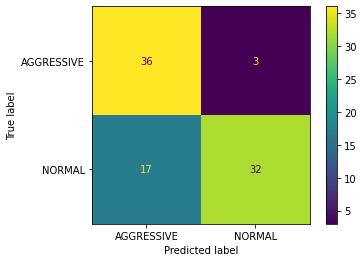

In [42]:
Y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(actual_y_test, Y_pred)

classes = ['AGGRESSIVE', 'NORMAL']
disp = ConfusionMatrixDisplay.from_predictions(actual_y_test, Y_pred, display_labels=classes)

plt.rcParams['figure.figsize'] = [20, 10]
plt.show()
